# Download the mzML File

In [1]:
import urllib.request

# Paste your URL here
url = "https://ftp.pride.ebi.ac.uk/pride/data/archive/2025/05/PXD044513/NB_Jan2021_120mins_OTIT_A5_1.mzML"  
filename = "NB_Jan2021_120mins_OTIT_A5_1.mzML"

print(f"Downloading {filename}...")
urllib.request.urlretrieve(url, filename)
print(f"Download complete! File saved as {filename}")

Download complete! File saved as NB_Jan2021_120mins_OTIT_A5_1.mzML


# Load and Check the File

In [2]:
from pyteomics import mzml
import pandas as pd
import numpy as np

# Quick verification - count spectra
print("Loading mzML file...")
with mzml.read(filename) as reader:
    spectrum_count = sum(1 for _ in reader)
    
print(f"Successfully loaded! Total spectra: {spectrum_count}")

Loading mzML file...
Successfully loaded! Total spectra: 48537


# Extract Spectrum Information

In [3]:
# Collect metadata from all spectra
spectra_info = []

with mzml.read(filename) as reader:
    for spectrum in reader:
        spectra_info.append({
            'scan_id': spectrum.get('id'),
            'ms_level': spectrum.get('ms level'),
            'retention_time': spectrum.get('scanList', {}).get('scan', [{}])[0].get('scan start time', None),
            'num_peaks': len(spectrum.get('m/z array', [])),
            'base_peak_intensity': max(spectrum.get('intensity array', [0]))
        })

# Convert to DataFrame
df = pd.DataFrame(spectra_info)
print(df.head(10))
print(f"\nDataFrame shape: {df.shape}")

                 scan_id  ms_level  retention_time  num_peaks  \
0  scan=19866 file=13544         2       42.860755       1046   
1  scan=19902 file=13544         2       42.929189       1001   
2  scan=24759 file=13544         2       50.242617        931   
3  scan=66033 file=13544         2      101.701404       1060   
4  scan=66169 file=13544         2      101.848604       1188   
5  scan=66341 file=13544         2      102.037641       1253   
6   scan=5707 file=13544         2       21.712963        594   
7   scan=5797 file=13544         2       21.817847        791   
8   scan=7341 file=13544         2       23.741014        715   
9  scan=11801 file=13544         2       30.400886        854   

   base_peak_intensity  
0         54785.089844  
1         68755.953125  
2         44971.531250  
3         21658.849609  
4        170490.406250  
5         35062.050781  
6         18360.869141  
7         13373.969727  
8         26680.720703  
9         32575.130859  

DataFram

# Basic Data Exploration

In [5]:
# Summary statistics
print("=== Dataset Summary ===")
print(f"MS1 spectra: {len(df[df['ms_level']==1])}")
print(f"MS2 spectra: {len(df[df['ms_level']==2])}")
print(f"\nRetention time range: {df['retention_time'].min():.2f} - {df['retention_time'].max():.2f} minutes")
print(f"Average peaks per spectrum: {df['num_peaks'].mean():.0f}")

# Show distribution
print("\nPeaks per MS level:")
print(df.groupby('ms_level')['num_peaks'].describe())

=== Dataset Summary ===
MS1 spectra: 0
MS2 spectra: 48537

Retention time range: 14.50 - 129.99 minutes
Average peaks per spectrum: 1068

Peaks per MS level:
            count         mean         std   min    25%     50%     75%  \
ms_level                                                                  
2         48537.0  1067.509652  297.228093  21.0  863.0  1089.0  1299.0   

             max  
ms_level          
2         1750.0  


# Visualize a Single Spectrum

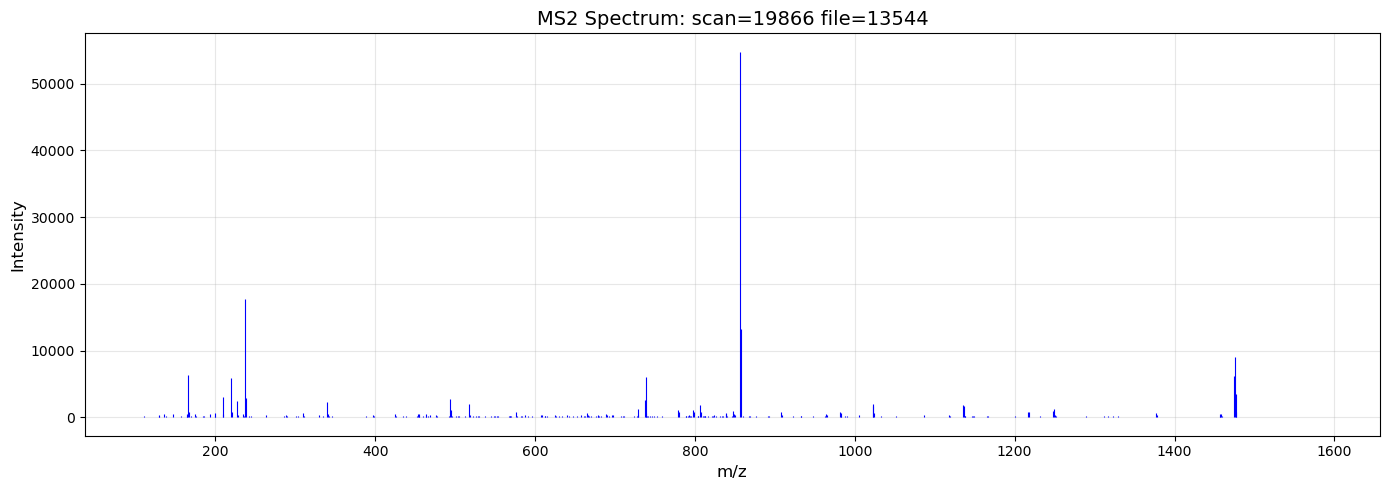

In [6]:
import matplotlib.pyplot as plt

# Extract one MS2 spectrum for visualization
with mzml.read(filename) as reader:
    for spectrum in reader:
        if spectrum.get('ms level') == 2:  # Get first MS2 spectrum
            mz = spectrum['m/z array']
            intensity = spectrum['intensity array']
            scan_id = spectrum.get('id')
            
            # Plot
            plt.figure(figsize=(14, 5))
            plt.vlines(mz, 0, intensity, colors='blue', linewidth=0.8)
            plt.xlabel('m/z', fontsize=12)
            plt.ylabel('Intensity', fontsize=12)
            plt.title(f'MS2 Spectrum: {scan_id}', fontsize=14)
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()
            break

# Downloading corresponding results files, linking identification to spectra, quality control metrics, Analysis

In [12]:
# Specify the filename (it should be in your current working directory)
mzid_filename = 'NB_Jan2021_120mins_OTIT_A5_1.mzid'

# Check if file exists first
import os
if os.path.exists(mzid_filename):
    print(f"File found: {mzid_filename}")
else:
    print(f"File not found! Current directory: {os.getcwd()}")
    print(f"Files in current directory: {os.listdir('.')}")

File found: NB_Jan2021_120mins_OTIT_A5_1.mzid


In [13]:
from pyteomics import mzid
import pandas as pd

In [14]:
# Read the identification results
print("Loading identification file...")
identifications = list(mzid.read(mzid_filename))
print(f"Total identifications: {len(identifications)}")

# Look at the first identification
print("\nFirst identification structure:")
print(identifications[0].keys())

Loading identification file...
Total identifications: 34094

First identification structure:
dict_keys(['spectrumID', 'SpectrumIdentificationItem', 'retention time', 'location', 'name', 'FileFormat', 'SpectrumIDFormat'])


# Extract Peptide and Protein Information

In [15]:
# Extract detailed peptide-spectrum match data
peptide_data = []

for psm in identifications:
    # Get peptide sequence
    peptide_seq = psm.get('SpectrumIdentificationItem', [{}])[0].get('PeptideSequence', None) if 'SpectrumIdentificationItem' in psm else None
    
    # Get charge state
    charge = psm.get('SpectrumIdentificationItem', [{}])[0].get('chargeState', None) if 'SpectrumIdentificationItem' in psm else None
    
    # Get scores (varies by search engine used)
    scores = psm.get('SpectrumIdentificationItem', [{}])[0] if 'SpectrumIdentificationItem' in psm else {}
    
    peptide_data.append({
        'spectrum_id': psm.get('spectrumID'),
        'retention_time': psm.get('retention time'),
        'peptide_sequence': peptide_seq,
        'charge': charge,
        'scan_info': psm.get('location', '')
    })

df_peptides = pd.DataFrame(peptide_data)
print(f"DataFrame shape: {df_peptides.shape}")
print(df_peptides.head(10))

DataFrame shape: (34094, 5)
             spectrum_id  retention_time peptide_sequence  charge  \
0  scan=19866 file=13544       42.860755  VHPEIINENGNPSYK       2   
1  scan=19902 file=13544       42.929189  VHPEIINENGNPSYK       3   
2  scan=24759 file=13544       50.242617        GFGDHIHWR       2   
3  scan=66033 file=13544      101.701404   YFYVSAEQVVQGMK       3   
4  scan=66169 file=13544      101.848604   YFYVSAEQVVQGMK       2   
5  scan=66341 file=13544      102.037641  EAAASGLPLMVIIHK       2   
6   scan=5707 file=13544       21.712963   HSLDASQGTATGPR       2   
7   scan=5797 file=13544       21.817847   HSLDASQGTATGPR       3   
8   scan=7341 file=13544       23.741014         IVVEEGSK       2   
9  scan=14577 file=13544       34.852858        VVDDELATR       2   

                                           scan_info  
0  G:\NiamhB_June2023\MS\All Files\NB_Jan2021_120...  
1  G:\NiamhB_June2023\MS\All Files\NB_Jan2021_120...  
2  G:\NiamhB_June2023\MS\All Files\NB_Jan2021_1

# Basic Data Quality Assessment

In [16]:
# Summary statistics
print("=== Peptide Identification Summary ===")
print(f"Total PSMs: {len(df_peptides)}")
print(f"Unique peptides: {df_peptides['peptide_sequence'].nunique()}")
print(f"\nCharge state distribution:")
print(df_peptides['charge'].value_counts().sort_index())

# Retention time distribution
print(f"\nRetention time range: {df_peptides['retention_time'].min():.2f} - {df_peptides['retention_time'].max():.2f} minutes")

# Check for missing values
print(f"\nMissing values:")
print(df_peptides.isnull().sum())

=== Peptide Identification Summary ===
Total PSMs: 34094
Unique peptides: 21720

Charge state distribution:
charge
2    25677
3     7603
4      745
5       61
6        8
Name: count, dtype: int64

Retention time range: 15.39 - 129.99 minutes

Missing values:
spectrum_id         0
retention_time      0
peptide_sequence    0
charge              0
scan_info           0
dtype: int64


# Link Identifications to MS2 Spectra

In [17]:
# Link back to your MS2 spectra DataFrame from earlier
# This shows identification rate

print(f"Total MS2 spectra: {len(df)}")  # From your earlier mzML analysis
print(f"Identified spectra: {len(df_peptides)}")
print(f"Identification rate: {len(df_peptides)/len(df)*100:.1f}%")

Total MS2 spectra: 48537
Identified spectra: 34094
Identification rate: 70.2%


# Peptide Length Distribution

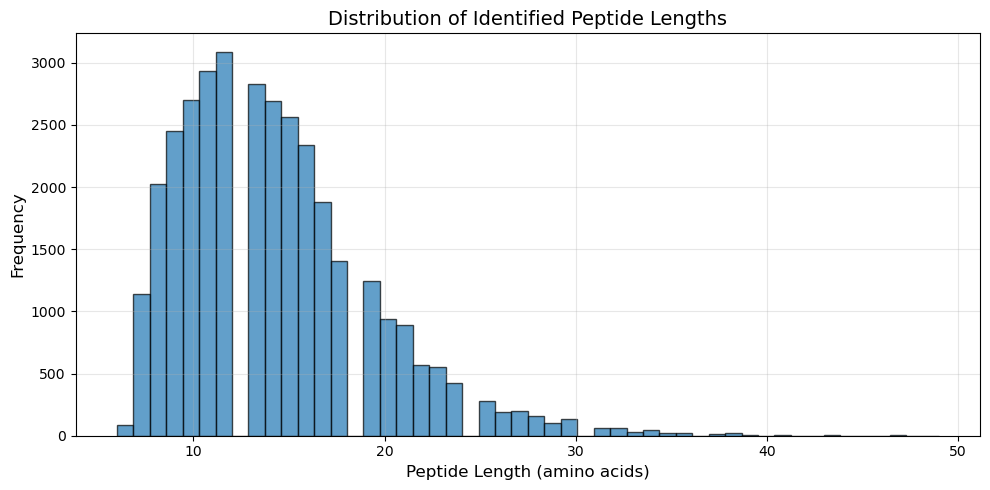

Mean peptide length: 14.2 aa
Median peptide length: 13 aa


In [18]:
import matplotlib.pyplot as plt

# Calculate peptide lengths
df_peptides['peptide_length'] = df_peptides['peptide_sequence'].str.len()

plt.figure(figsize=(10, 5))
plt.hist(df_peptides['peptide_length'].dropna(), bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Peptide Length (amino acids)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Identified Peptide Lengths', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Mean peptide length: {df_peptides['peptide_length'].mean():.1f} aa")
print(f"Median peptide length: {df_peptides['peptide_length'].median():.0f} aa")

# Identification Over Retention Time

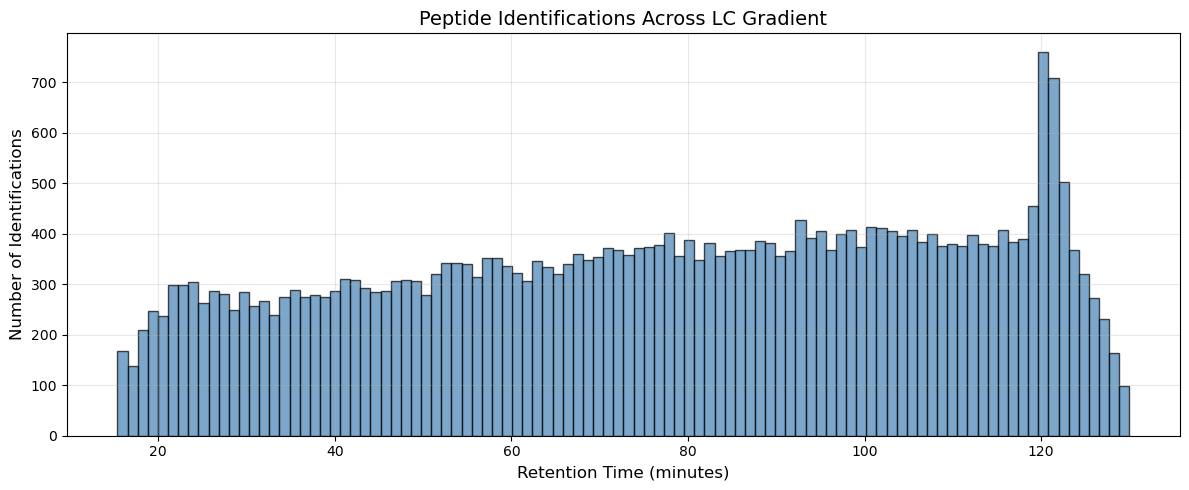

In [19]:
# Plot identifications across LC gradient
plt.figure(figsize=(12, 5))
plt.hist(df_peptides['retention_time'].dropna(), bins=100, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Retention Time (minutes)', fontsize=12)
plt.ylabel('Number of Identifications', fontsize=12)
plt.title('Peptide Identifications Across LC Gradient', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate Identification Rate

In [20]:
# Link identifications to MS2 spectra
print("=== Identification Rate Analysis ===")
print(f"Total MS2 spectra acquired: {len(df)}")
print(f"Successfully identified spectra (PSMs): {len(df_peptides)}")
print(f"Unidentified spectra: {len(df) - len(df_peptides)}")
print(f"\nIdentification rate: {len(df_peptides)/len(df)*100:.1f}%")
print(f"Miss rate: {(len(df) - len(df_peptides))/len(df)*100:.1f}%")

=== Identification Rate Analysis ===
Total MS2 spectra acquired: 48537
Successfully identified spectra (PSMs): 34094
Unidentified spectra: 14443

Identification rate: 70.2%
Miss rate: 29.8%


# Analyze Peptide Sequence Properties

In [21]:
# Analyze amino acid composition and properties
import re

def count_basic_residues(seq):
    """Count lysine (K) and arginine (R) - trypsin cleavage sites"""
    return seq.count('K') + seq.count('R')

def count_missed_cleavages(seq):
    """Count internal K/R that weren't cleaved"""
    # Tryptic peptides should end in K or R, so internal ones are missed cleavages
    internal = seq[:-1] if len(seq) > 0 else ""
    return internal.count('K') + internal.count('R')

# Apply to peptides
df_peptides['num_basic_residues'] = df_peptides['peptide_sequence'].apply(count_basic_residues)
df_peptides['missed_cleavages'] = df_peptides['peptide_sequence'].apply(count_missed_cleavages)

print("=== Missed Cleavage Analysis ===")
print(df_peptides['missed_cleavages'].value_counts().sort_index())
print(f"\nPercentage with 0 missed cleavages: {(df_peptides['missed_cleavages']==0).sum()/len(df_peptides)*100:.1f}%")
print(f"Percentage with 1+ missed cleavages: {(df_peptides['missed_cleavages']>=1).sum()/len(df_peptides)*100:.1f}%")

=== Missed Cleavage Analysis ===
missed_cleavages
0    29010
1     4698
2      368
3       18
Name: count, dtype: int64

Percentage with 0 missed cleavages: 85.1%
Percentage with 1+ missed cleavages: 14.9%


# Charge State vs Peptide Length Analysis

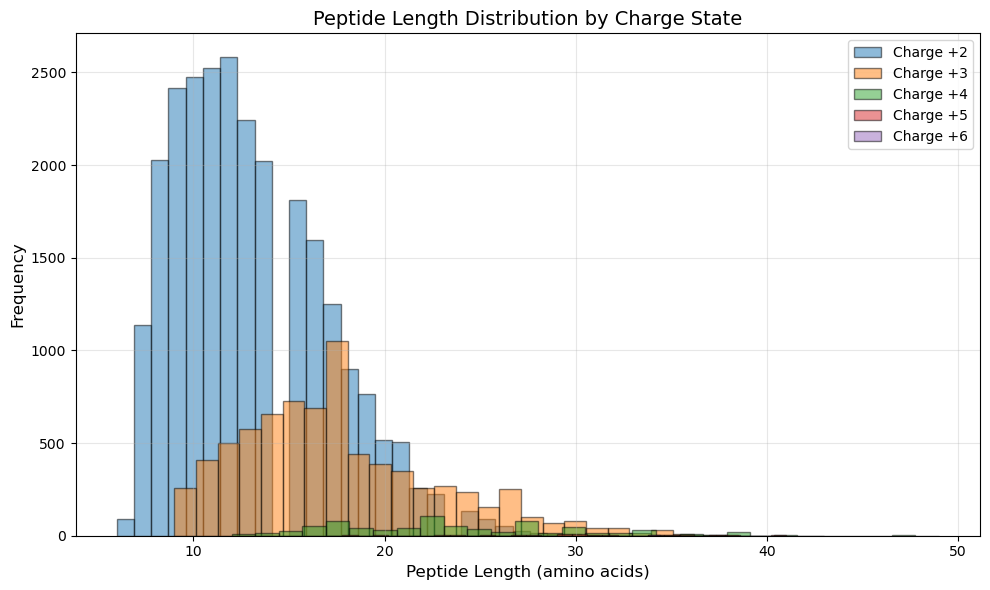


=== Peptide Length by Charge State ===
          count       mean       std   min    25%   50%   75%   max
charge                                                             
2       25677.0  12.944581  4.025314   6.0  10.00  12.0  15.0  33.0
3        7603.0  17.552940  5.170233   9.0  14.00  16.0  21.0  43.0
4         745.0  23.896644  6.396513  12.0  19.00  23.0  28.0  49.0
5          61.0  29.803279  5.870320  17.0  27.00  30.0  35.0  41.0
6           8.0  32.875000  5.488625  23.0  29.75  34.0  35.5  41.0


In [22]:
# Relationship between peptide length and charge state
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for charge in sorted(df_peptides['charge'].unique()):
    subset = df_peptides[df_peptides['charge'] == charge]
    plt.hist(subset['peptide_length'], bins=30, alpha=0.5, label=f'Charge +{charge}', edgecolor='black')

plt.xlabel('Peptide Length (amino acids)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Peptide Length Distribution by Charge State', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Statistical summary
print("\n=== Peptide Length by Charge State ===")
print(df_peptides.groupby('charge')['peptide_length'].describe())

# Extract Protein-Level Information

In [23]:
# First, let's look deeper into the identification structure to extract protein info
print("=== Examining Protein Information ===")
# Get first identification and explore its structure
first_id = identifications[0]
if 'SpectrumIdentificationItem' in first_id:
    spec_item = first_id['SpectrumIdentificationItem'][0]
    print("Available fields in SpectrumIdentificationItem:")
    print(spec_item.keys())
    print("\nSample data:")
    for key in list(spec_item.keys())[:10]:  # First 10 keys
        print(f"{key}: {spec_item.get(key)}")

=== Examining Protein Information ===
Available fields in SpectrumIdentificationItem:
dict_keys(['passThreshold', 'rank', 'experimentalMassToCharge', 'calculatedMassToCharge', 'chargeState', 'PeptideEvidenceRef', 'Proteome Discoverer Delta Score', 'PeptideSequence'])

Sample data:
passThreshold: True
rank: 1
experimentalMassToCharge: 855.92333984375
calculatedMassToCharge: 855.925925355
chargeState: 2
PeptideEvidenceRef: [{'post': 'Y', 'pre': 'K', 'end': 137, 'start': 123, 'PeptideSequence': 'VHPEIINENGNPSYK', 'accession': 'O95881', 'length': 172, 'Seq': 'METRPRLGATCLLGFSFLLLVISSDGHNGLGKGFGDHIHWRTLEDGKKEAAASGLPLMVIIHKSWCGACKALKPKFAESTEISELSHNFVMVNLEDEEEPKDEDFSPDGGYIPRILFLDPSGKVHPEIINENGNPSYKYFYVSAEQVVQGMKEAQERLTGDAFRKKHLEDEL', 'protein description': 'Thioredoxin domain-containing protein 12 OS=Homo sapiens OX=9606 GN=TXNDC12 PE=1 SV=1', 'location': 'C:\\', 'FileFormat': 'FASTA format', 'DatabaseName': {'UniProtKB_Human_Jan2023.fasta.fasta': ''}, 'DB composition target+decoy': ''}]
Prot

# Create Summary Statistics Table

In [24]:
# Comprehensive summary table
summary_stats = {
    'Metric': [
        'Total MS2 Spectra',
        'Identified Spectra (PSMs)',
        'Unique Peptides',
        'Identification Rate (%)',
        'Mean Peptide Length (aa)',
        'Median Peptide Length (aa)',
        'Retention Time Range (min)',
        'Predominant Charge State',
        'Mean Peaks per Spectrum'
    ],
    'Value': [
        f"{len(df):,}",
        f"{len(df_peptides):,}",
        f"{df_peptides['peptide_sequence'].nunique():,}",
        f"{len(df_peptides)/len(df)*100:.1f}",
        f"{df_peptides['peptide_length'].mean():.1f}",
        f"{df_peptides['peptide_length'].median():.0f}",
        f"{df_peptides['retention_time'].min():.1f} - {df_peptides['retention_time'].max():.1f}",
        f"+{df_peptides['charge'].mode()[0]} ({(df_peptides['charge']==df_peptides['charge'].mode()[0]).sum()/len(df_peptides)*100:.1f}%)",
        f"{df['num_peaks'].mean():.0f}"
    ]
}

summary_df = pd.DataFrame(summary_stats)
print("\n=== Dataset Summary Table ===")
print(summary_df.to_string(index=False))


=== Dataset Summary Table ===
                    Metric        Value
         Total MS2 Spectra       48,537
 Identified Spectra (PSMs)       34,094
           Unique Peptides       21,720
   Identification Rate (%)         70.2
  Mean Peptide Length (aa)         14.2
Median Peptide Length (aa)           13
Retention Time Range (min) 15.4 - 130.0
  Predominant Charge State   +2 (75.3%)
   Mean Peaks per Spectrum         1068


# Retention Time vs Peptide Properties

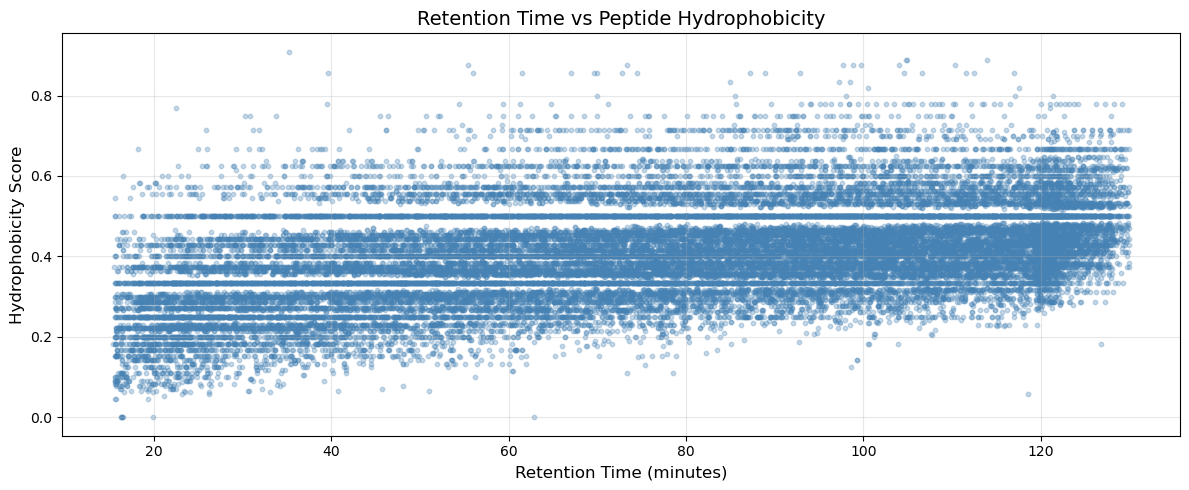


=== Retention Time Correlation ===
                retention_time  hydrophobicity  peptide_length
retention_time        1.000000        0.454811        0.506936
hydrophobicity        0.454811        1.000000       -0.147514
peptide_length        0.506936       -0.147514        1.000000


In [25]:
# Analyze relationship between retention time and hydrophobicity
def calculate_hydrophobicity(seq):
    """Simple hydrophobicity score - count hydrophobic amino acids"""
    hydrophobic = 'AVILMFYW'
    return sum(1 for aa in seq if aa in hydrophobic) / len(seq) if len(seq) > 0 else 0

df_peptides['hydrophobicity'] = df_peptides['peptide_sequence'].apply(calculate_hydrophobicity)

# Plot retention time vs hydrophobicity
plt.figure(figsize=(12, 5))
plt.scatter(df_peptides['retention_time'], df_peptides['hydrophobicity'], 
            alpha=0.3, s=10, c='steelblue')
plt.xlabel('Retention Time (minutes)', fontsize=12)
plt.ylabel('Hydrophobicity Score', fontsize=12)
plt.title('Retention Time vs Peptide Hydrophobicity', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n=== Retention Time Correlation ===")
correlation = df_peptides[['retention_time', 'hydrophobicity', 'peptide_length']].corr()
print(correlation)

# Prepare for Comparative Analysis

In [26]:
# Save processed data for comparison with control
df_peptides.to_csv('DHFR_KO_peptides.csv', index=False)
print("\n=== Data Export ===")
print("Saved processed peptide data to: DHFR_KO_peptides.csv")
print(f"Columns: {list(df_peptides.columns)}")
print(f"Total rows: {len(df_peptides)}")


=== Data Export ===
Saved processed peptide data to: DHFR_KO_peptides.csv
Columns: ['spectrum_id', 'retention_time', 'peptide_sequence', 'charge', 'scan_info', 'peptide_length', 'num_basic_residues', 'missed_cleavages', 'hydrophobicity']
Total rows: 34094
